In [45]:
from theano.sandbox import cuda

In [46]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

In [47]:
path = "data/ml-latest-small/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

In [48]:
# The folder that contains movie + user data that analysis will be performed on.
ratings = pd.read_csv(path+'ratings.csv')
# The first rows show that the data consists of 4 columns()
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [49]:
len(ratings)

100004

In [50]:
# This is a way to access the name of the movie, for visualizing purposes.
# names_movies = pd.read_csv(path+'movies.csv')
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [51]:
# There are 9125 movies
len(movie_names)

9125

In [52]:
# Unique users and movies are deciphered to ensure that unnecessary noise is reduced.
users = ratings.userId.unique()
# There are 671 unique users
print(len(users))
movies = ratings.movieId.unique()
# There are 9066 unique movies.
print(len(movies))

671
9066


In [53]:
# Each unique user and movie is enumerated and individual user:index key values are generated. 
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

In [54]:
# User & movie IDs are updated such that they are
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [55]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
# Below, it is confirmed that there are 671 unique users
# And there are 9066 movies.
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [56]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

In [57]:
# Declaring and arbitrary number(50) that are the number of latent factors
# For creating each embedding.
n_factors = 50

In [58]:
# This allows for controlled randomness of the numbers.
np.random.seed = 42

In [72]:
# Data is split randomly between training and test data
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
# print(trn.head)
# 80294 training data
print(len(trn))
val = ratings[~msk]
# 1970 validation data
print(len(val))
# print(val.head)

80294
19710


In [60]:
# g grabs userId by rating and
g=ratings.groupby('userId')['rating'].count()
# then the top 15 users that watch the most movies.
topUsers=g.sort_values(ascending=False)[:15]
topUsers.head()

userId
546    2391
563    1868
623    1735
14     1700
72     1610
Name: rating, dtype: int64

In [61]:
# again, g is the variable that finds the movies that have been rated the most fequently
g=ratings.groupby('movieId')['rating'].count()
# These are the 15 most watched movies
topMovies=g.sort_values(ascending=False)[:15]
topMovies.head()

movieId
57     341
49     324
99     311
92     304
143    291
Name: rating, dtype: int64

In [62]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r.head()

,userId,movieId,rating,timestamp,rating_r
962,14,417,2.0,997938310,1700
963,14,650,2.0,1134521380,1700
964,14,651,4.5,1093070098,1700
965,14,652,4.0,1040205753,1700
966,14,20,3.0,1093028290,1700


In [63]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')
top_r.head()

,userId,movieId,rating,timestamp,rating_r,rating_r
962,14,417,2.0,997938310,1700,247
5048,29,417,4.0,944943070,1011,247
10214,72,417,5.0,1303464840,1610,247
28390,211,417,3.0,1218405007,876,247
29266,212,417,3.0,1462637445,910,247


In [64]:
# The crosstab shows great insight, and also it shows that users 
# 14, 29 and 72 have watched an rated every single movie.
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


In [65]:
# The most basic model is a dotproduct of the user embedding & the movie embedding.
# user_in is the input vector of the user
user_in = Input(shape=(1,), dtype='int64', name='user_in')
# u is/are the embeddings for each user. So, the inputs to the Emberdding() function are
# Embedding(671, 50, input_lenght=1, W_regularizer=l2(le-4))(user_in)
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
# The Embedding is a Tensor and is associated with Theano
print(type(u))

# The same as above, but this time for an input of each movie.
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)
# The Embedding is a Tensor and is associated with Theano and it is the movie embedding 
# That consists of 50 latent factors.
print(type(m))


<class 'theano.tensor.var.TensorVariable'>
<class 'theano.tensor.var.TensorVariable'>


In [68]:
# The dot product of the embeddings is calculated
x = merge([u, m], mode='dot')
print(u)
x = Flatten()(x)
print(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

model.summary()

Reshape{3}.0
Reshape{2}.0
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
_________________________________________________________________

In [69]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79986 samples, validate on 20018 samples
Epoch 1/1
79986/79986 [==============================] - 6s - loss: 9.9232 - val_loss: 3.9052


In [70]:
model.optimizer.lr=0.01

In [71]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79986 samples, validate on 20018 samples
Epoch 1/3
79986/79986 [==============================] - 6s - loss: 3.1301 - val_loss: 2.0775
Epoch 2/3
79986/79986 [==============================] - 6s - loss: 2.4075 - val_loss: 1.6918
Epoch 3/3
79986/79986 [==============================] - 6s - loss: 2.2400 - val_loss: 1.5622


In [73]:
model.optimizer.lr=0.001

In [74]:
# Since this data has been tested far and wide, the closest benchmark is at
# a loss of 0.9, but I am doing considerably poorly. The next step will
# be a step to decrease that loss value.
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80294 samples, validate on 19710 samples
Epoch 1/6
80294/80294 [==============================] - 6s - loss: 2.2494 - val_loss: 1.2160
Epoch 2/6
80294/80294 [==============================] - 6s - loss: 2.1705 - val_loss: 1.2980
Epoch 3/6
80294/80294 [==============================] - 6s - loss: 2.1307 - val_loss: 1.3621
Epoch 4/6
80294/80294 [==============================] - 6s - loss: 2.1013 - val_loss: 1.4119
Epoch 5/6
80294/80294 [==============================] - 6s - loss: 2.0776 - val_loss: 1.4223
Epoch 6/6
80294/80294 [==============================] - 6s - loss: 2.0555 - val_loss: 1.4284


In [75]:
# In order to decrease the loss function further, biases are added for each movie
# and each user to represent how positive or negative each user is and how good a movie is.

# It is calculated by creating an embedding
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [76]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [77]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [78]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [79]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [81]:
# Achieved state of the art according to http://www.librec.net/example.html
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80294 samples, validate on 19710 samples
Epoch 1/6
80294/80294 [==============================] - 6s - loss: 2.5965 - val_loss: 1.6274
Epoch 2/6
80294/80294 [==============================] - 6s - loss: 1.9928 - val_loss: 1.3401
Epoch 3/6
80294/80294 [==============================] - 6s - loss: 1.8291 - val_loss: 1.2309
Epoch 4/6
80294/80294 [==============================] - 6s - loss: 1.7352 - val_loss: 1.1727
Epoch 5/6
80294/80294 [==============================] - 6s - loss: 1.6552 - val_loss: 1.1317
Epoch 6/6
80294/80294 [==============================] - 6s - loss: 1.5806 - val_loss: 1.1000


In [82]:
model.optimizer.lr=0.01

In [83]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80294 samples, validate on 19710 samples
Epoch 1/6
80294/80294 [==============================] - 6s - loss: 1.5083 - val_loss: 1.0794
Epoch 2/6
80294/80294 [==============================] - 6s - loss: 1.4393 - val_loss: 1.0477
Epoch 3/6
80294/80294 [==============================] - 6s - loss: 1.3711 - val_loss: 1.0225
Epoch 4/6
80294/80294 [==============================] - 6s - loss: 1.3053 - val_loss: 0.9985
Epoch 5/6
80294/80294 [==============================] - 6s - loss: 1.2424 - val_loss: 0.9780
Epoch 6/6
80294/80294 [==============================] - 6s - loss: 1.1814 - val_loss: 0.9558


In [84]:
model.optimizer.lr=0.001

In [85]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80294 samples, validate on 19710 samples
Epoch 1/10
80294/80294 [==============================] - 6s - loss: 1.1240 - val_loss: 0.9353
Epoch 2/10
80294/80294 [==============================] - 6s - loss: 1.0697 - val_loss: 0.9166
Epoch 3/10
80294/80294 [==============================] - 6s - loss: 1.0176 - val_loss: 0.8981
Epoch 4/10
80294/80294 [==============================] - 6s - loss: 0.9680 - val_loss: 0.8825
Epoch 5/10
80294/80294 [==============================] - 6s - loss: 0.9217 - val_loss: 0.8715
Epoch 6/10
80294/80294 [==============================] - 6s - loss: 0.8784 - val_loss: 0.8551
Epoch 7/10
80294/80294 [==============================] - 6s - loss: 0.8377 - val_loss: 0.8441
Epoch 8/10
80294/80294 [==============================] - 6s - loss: 0.8004 - val_loss: 0.8344
Epoch 9/10
80294/80294 [==============================] - 6s - loss: 0.7662 - val_loss: 0.8251
Epoch 10/10
80294/80294 [==============================] - 6s - loss: 0.7352 - val_loss: 0.8169

In [86]:
model.save_weights(model_path+'bias2.h5')

In [87]:
model.load_weights(model_path+'bias2.h5')

In [88]:
model.predict([np.array([3]), np.array([6])])

array([[ 5.1335]], dtype=float32)

In [89]:
g=ratings.groupby('movieId')['rating'].count()
# Got top 2000 movies
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

In [90]:
# Retrieved movie bias
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)]

In [91]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.67090499, 'Battlefield Earth (2000)'),
 (-0.13998389, 'Super Mario Bros. (1993)'),
 (-0.11310647, 'Spice World (1997)'),
 (-0.10678747, '2 Fast 2 Furious (Fast and the Furious 2, The) (2003)'),
 (-0.089970402, 'Speed 2: Cruise Control (1997)'),
 (-0.077303201, 'Jaws 3-D (1983)'),
 (-0.062270716, 'Howard the Duck (1986)'),
 (-0.043816574, 'Blade: Trinity (2004)'),
 (-0.034655627, 'Little Nicky (2000)'),
 (-0.024137374, 'Police Academy 6: City Under Siege (1989)'),
 (-0.0091406023, 'Scary Movie 2 (2001)'),
 (0.018790871, 'Wild Wild West (1999)'),
 (0.022190509, 'Two Weeks Notice (2002)'),
 (0.032256741, 'Blair Witch Project, The (1999)'),
 (0.032346282, 'Avengers, The (1998)')]

In [92]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.5126916, 'Harry Potter and the Deathly Hallows: Part 2 (2011)'),
 (1.4667146, "Howl's Moving Castle (Hauru no ugoku shiro) (2004)"),
 (1.4421961, 'Persuasion (1995)'),
 (1.414791, 'Rush (2013)'),
 (1.4122473, 'Smoke (1995)'),
 (1.4109354, 'Tom Jones (1963)'),
 (1.3998991, 'The Theory of Everything (2014)'),
 (1.3877332, 'Shawshank Redemption, The (1994)'),
 (1.3743449, 'My Neighbor Totoro (Tonari no Totoro) (1988)'),
 (1.3598726, 'Argo (2012)'),
 (1.3338209, 'Ideal Husband, An (1999)'),
 (1.3285607, 'Three Colors: White (Trzy kolory: Bialy) (1994)'),
 (1.3179862, "Amores Perros (Love's a Bitch) (2000)"),
 (1.3114648, 'Coraline (2009)'),
 (1.3077432, 'Cyrano de Bergerac (1990)')]

In [93]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

In [94]:
# Principal component analysis.
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [95]:
fac0 = movie_pca[0]

In [96]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

In [97]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.057500873, 'Usual Suspects, The (1995)'),
 (0.055245526, "Schindler's List (1993)"),
 (0.053779479, "Amelie (Fabuleux destin d'Am\xc3\xa9lie Poulain, Le) (2001)"),
 (0.053020526, 'Shawshank Redemption, The (1994)'),
 (0.051712453, 'American Beauty (1999)'),
 (0.050697885, 'Clerks (1994)'),
 (0.049610991, 'Toy Story (1995)'),
 (0.04953441, 'Wallace & Gromit: The Wrong Trousers (1993)'),
 (0.049137373, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.048855308, 'Good Will Hunting (1997)')]

In [98]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.016163029, 'Anaconda (1997)'),
 (-0.012412233, 'Blade: Trinity (2004)'),
 (-0.0104986, 'RoboCop 3 (1993)'),
 (-0.010415621, 'House on Haunted Hill (1999)'),
 (-0.010318855, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.0095802452, 'Godzilla (1998)'),
 (-0.0090828463, 'Bio-Dome (1996)'),
 (-0.0085514793, "Charlie's Angels: Full Throttle (2003)"),
 (-0.0083495816, 'Police Academy 6: City Under Siege (1989)'),
 (-0.0080892453, 'Police Academy 4: Citizens on Patrol (1987)')]

In [99]:
fac1 = movie_pca[1]

In [100]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

In [101]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.068652339, 'Annie Hall (1977)'),
 (0.065295853, 'City Lights (1931)'),
 (0.06173908, 'Brokeback Mountain (2005)'),
 (0.060132235, '8 1/2 (8\xc2\xbd) (1963)'),
 (0.055869583, 'Vertigo (1958)'),
 (0.055579409, 'Apocalypse Now (1979)'),
 (0.054764878, 'Clockwork Orange, A (1971)'),
 (0.053999361, 'Big Lebowski, The (1998)'),
 (0.053518504, 'Gosford Park (2001)'),
 (0.05295556, 'Manhattan (1979)')]

In [102]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.099410541, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.092667378, 'Armageddon (1998)'),
 (-0.075973913, 'True Lies (1994)'),
 (-0.075788356, 'Stargate (1994)'),
 (-0.073458269, 'Rock, The (1996)'),
 (-0.073197052, 'Star Wars: Episode I - The Phantom Menace (1999)'),
 (-0.072072849, 'Star Trek: First Contact (1996)'),
 (-0.070541248, 'Speed (1994)'),
 (-0.070445083, 'Braveheart (1995)'),
 (-0.068875812, 'Outbreak (1995)')]

In [103]:
fac2 = movie_pca[2]

In [104]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

In [105]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.076973669, 'Beauty and the Beast (1991)'),
 (0.076873191, 'Legally Blonde (2001)'),
 (0.07633584, "You've Got Mail (1998)"),
 (0.075173974, 'Finding Nemo (2003)'),
 (0.07263495, 'Little Mermaid, The (1989)'),
 (0.068254404,
  'Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)'),
 (0.065804549, 'Sabrina (1995)'),
 (0.064821534, 'Sliding Doors (1998)'),
 (0.064527601, 'Grease (1978)'),
 (0.063355245, 'Arsenic and Old Lace (1944)')]

In [106]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.14251129, 'Seven (a.k.a. Se7en) (1995)'),
 (-0.10048734, 'Pulp Fiction (1994)'),
 (-0.0868515, 'Clockwork Orange, A (1971)'),
 (-0.08677233, 'Eyes Wide Shut (1999)'),
 (-0.080179766, 'Fight Club (1999)'),
 (-0.078672215, 'Dumb & Dumber (Dumb and Dumber) (1994)'),
 (-0.078587286, 'Fear and Loathing in Las Vegas (1998)'),
 (-0.077143736, 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)'),
 (-0.075365685,
  'L\xc3\xa9on: The Professional (a.k.a. The Professional) (L\xc3\xa9on) (1994)'),
 (-0.074834183, 'Nightmare Before Christmas, The (1993)')]

In [107]:
reload(sys)
sys.setdefaultencoding('utf8')

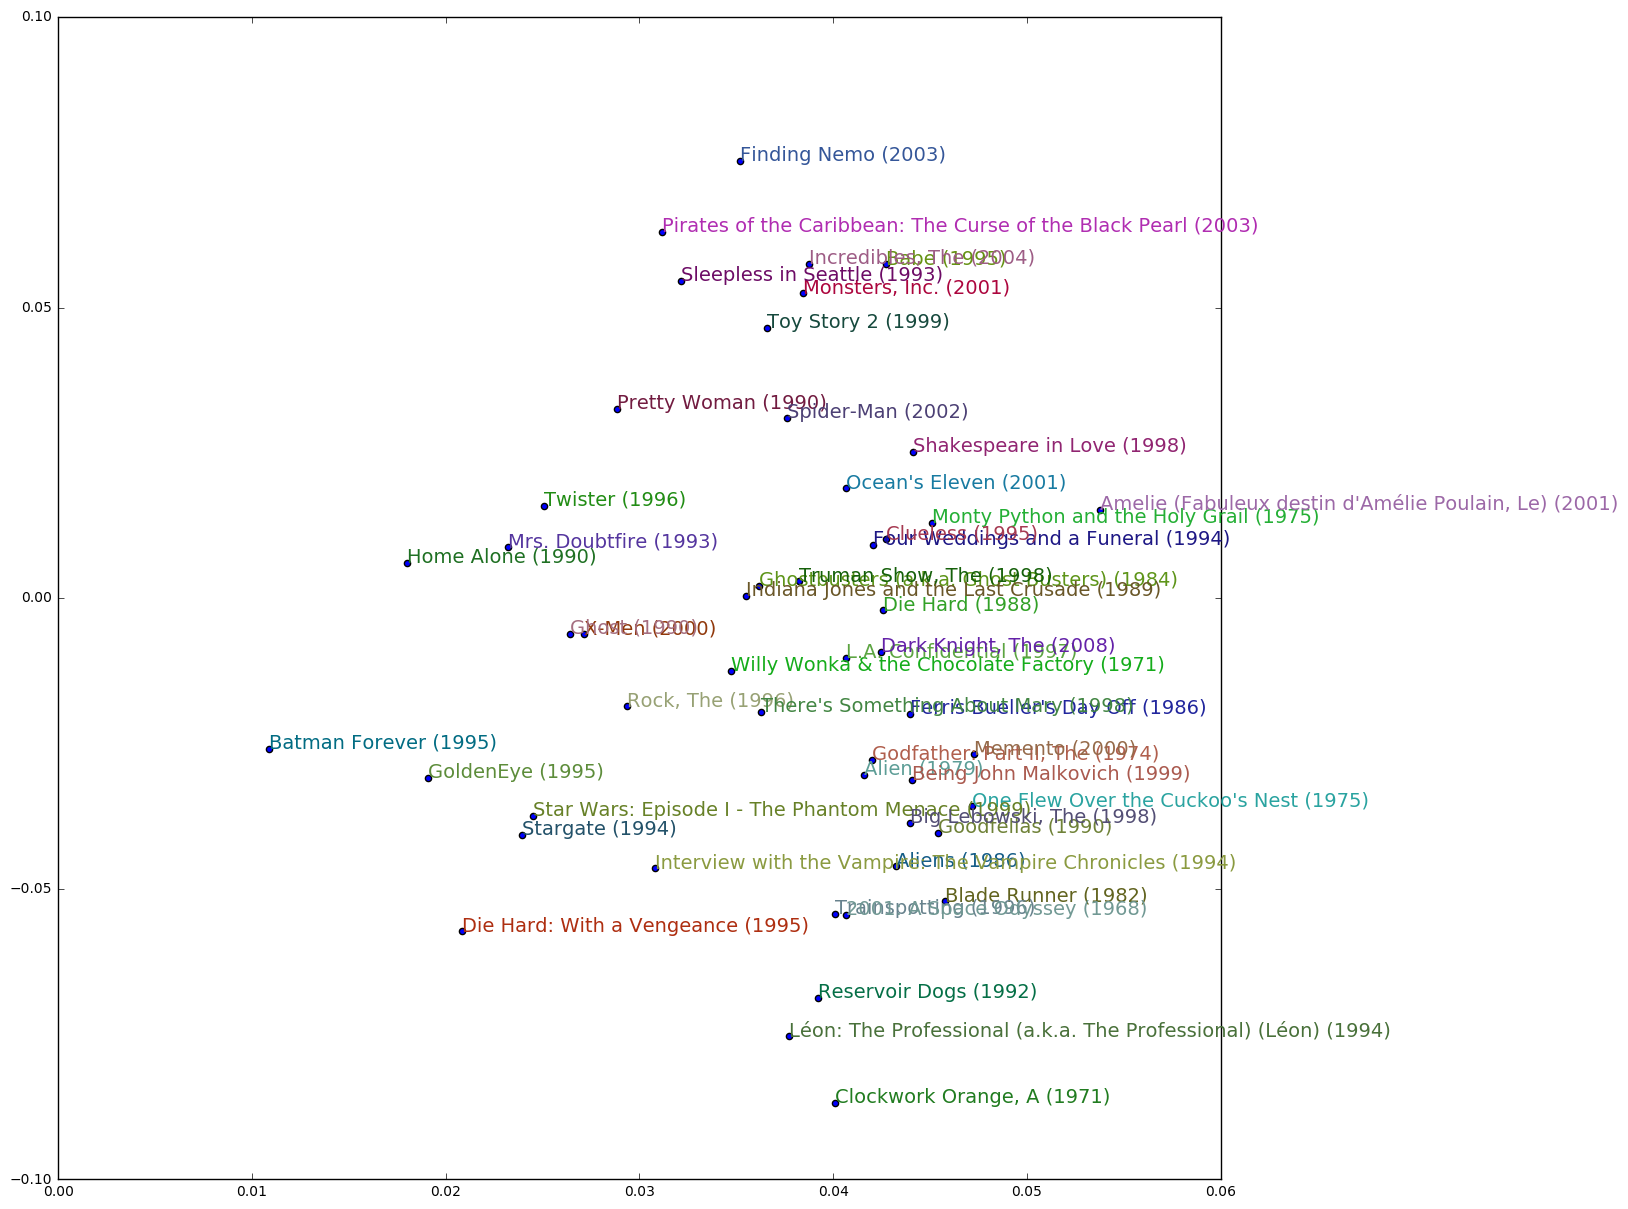

In [108]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

In [109]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [110]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [111]:
# 0.7881 accuracy
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=8, 
          validation_data=([val.userId, val.movieId], val.rating))